## Importing libraries


In [38]:
# -*- coding: utf-8 -*-
"""
Created on Tue Jul 25 23:26:42 2023

@author: DELL
"""
!pip install mne_bids
!pip install mne
!pip install seaborn
!pip install tensorflow
 #%%
import matplotlib
import pathlib
import os
import mne
import csv
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
from mne.io import read_raw_eeglab
from mne_bids import BIDSPath, get_entity_vals, find_matching_paths
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sklearn
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
mne.set_log_level('warning')
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, message="Data will be preloaded.*")
print('done')


[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
done


## Functions

In [3]:
# Function to plot training and validation accuracy/loss
def training_plot(history):
    # Extract training and validation accuracy and loss from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    # Plot training and validation loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
import matplotlib.pyplot as plt

def plot_accuracy(histories):
    plt.figure(figsize=(10, 6))
    
    for history in histories:
        acc = history.history['accuracy']
        #val_acc = history.history['val_accuracy']
        epochs = range(1, len(acc) + 1)

        plt.plot(epochs, acc, label='Training acc')
        #plt.plot(epochs, val_acc, label='Validation acc')

    plt.title('Training Acuraccy for each Fold in LOSO')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    #plt.legend()
    plt.grid(True)
    plt.show()


def calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP,model_title):
    # Calculate confusion matrix
    confusion_mtx = confusion_matrix(confusion_true_MLP, confusion_pred_MLP)

    # Define class names
    class_names = ["Control-CN(0)", " Alzhaimer-AD(1)"]
    #class_names = ["Control-CN(0)", " Dementia-FTD(1)"]

    # Calculate accuracy, sensitivity, specificity, precision, and F1-score
    accuracy = accuracy_score(confusion_true_MLP, confusion_pred_MLP)
    precision = precision_score(confusion_true_MLP, confusion_pred_MLP)
    recall = recall_score(confusion_true_MLP, confusion_pred_MLP)
    f1 = f1_score(confusion_true_MLP, confusion_pred_MLP)
    specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

    # Output metrics
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Sensitivity (Recall):", recall)
    print("Specificity:", specificity)
    print("F1-score:", f1)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_title)
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(confusion_true_MLP, confusion_pred_MLP)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()






def segmentation(data, labels, segment_duration=20,overlap=0.5):
    segmented_data, segmented_labels, idx = [], [], -1
    segmented_2D,segmented_2D_labels = [],[]
    overlap_duration = segment_duration * overlap

    for raw0 in data:
        temp_2D=[]
        temp_2D_labels=[]
        idx = idx + 1
        total_duration = raw0.times[-1]
        num_segments = int(total_duration // (segment_duration - overlap_duration)-1)
        print(raw0)

        for ii in range(num_segments):
            start_time = ii * (segment_duration - overlap_duration)
            end_time = min(start_time + segment_duration, total_duration)  # Ensure end_time doesn't exceed total_duration
            
            segment = raw0.copy().crop(tmin=start_time, tmax=end_time)
            segment_data = segment.get_data()
            
            segmented_data.append(segment)
            temp_2D.append(np.array(segment_data))
            
            segmented_labels.append(labels[idx])
            temp_2D_labels.append(labels[idx])
            
        
        segmented_2D.append(np.array(temp_2D))
        segmented_2D_labels.append(np.array(temp_2D_labels))
        print(end_time)
        

    # Create an array of indices
    num_samples = len(segmented_data)

    return segmented_2D, segmented_2D_labels

def calculate_rbp(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    epoch_data=epoch.get_data()
    
    for epoch in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(epoch, fs=fs, nperseg=fs*10, noverlap=fs*1)
        
        total_psd = np.trapz(psd, axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
    
    return np.array(rbp_features)

def shannon_entropy(signal):
    # Calculate the probability distribution of the signal
    unique_values, value_counts = np.unique(signal, return_counts=True)
    probabilities = value_counts /(signal.shape)
    
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy

    
import numpy as np
from scipy.signal import butter, filtfilt

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def calculate_rbp_filter(epoch, fs=500):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    
    for channel in epoch:
        rbp = []
        for band in frequency_bands:
            lowcut, highcut = band
            filtered_data = butter_bandpass_filter(channel, lowcut, highcut, fs)
            band_power = np.sum(filtered_data ** 2) / len(filtered_data)
            rbp.append(band_power)
        rbp_features.append(rbp)
    
    rbp_features = np.array(rbp_features)
    
    return rbp_features
print('done')

done


## Data Loading from file

In [3]:
total_subjects = 88 
num_subjects = 88 #How many subjects to include in analysis
random_subjects = True # Set this boolean to True to read subjects randomly

arr_info = np.empty((0, 5))

# Load participant data into 'arr' from a TSV file
with open("/kaggle/input/eeganalysis/AD_dataset/participants.tsv") as fd:
    rd = csv.reader(fd, delimiter="\t", quotechar='"')
    for row in rd:
        arr_info = np.append(arr_info, np.array([row]), axis=0)

#print(arr)

# Initialize lists to store segmented EEG data for each group (A, C, and F)
a_segments, c_segments, f_segments = [], [], []
selected_participants,selected_labels=[],[]
a_raw,c_raw,f_raw=[],[],[]
a_score,c_score,f_score=[],[],[]

a_age,c_age,f_age=[],[],[]


c_duration,a_duration,f_duration=[],[],[]

# Root directory for the BIDS dataset
bids_root = pathlib.Path('/kaggle/input/eeganalysis/AD_dataset/derivatives')

# Get available session values from the BIDS dataset
sessions = get_entity_vals(bids_root, 'session', ignore_sessions='on')

# Set the data type for BIDS search (EEG data)
datatype = 'eeg'

# File extensions to consider (ignore .json files)
extensions = [".bdf", ".tsv"]

# Find BIDS paths for the EEG data matching the specified criteria
bids_paths = find_matching_paths(bids_root, datatypes=datatype, sessions=sessions, extensions=extensions)

# Variables for averaging the scores in each group
asum, anum = 0, 0
csum, cnum = 0, 0
fsum, fnum = 0, 0

# Duration for segmenting the EEG data (in seconds)
segment_duration = 10

# Task name for the BIDS dataset
task = 'eyesclosed'

# Suffix for the BIDS dataset
suffix = 'eeg'

# Generate a list of subject indices (1 to total_subjects)
subject_indices = list(range(1, total_subjects))

# If random_subjects is True, shuffle the subject indices
if random_subjects:
    random.shuffle(subject_indices)

# Select a subset of subject indices for processing
subject_indices = subject_indices[:num_subjects]

# Iterate over subjects
for subj_idx in subject_indices:
    # Generate subject IDs in the format "001" to "088"
    subject = f'00{subj_idx}' if subj_idx <= 9 else f'0{subj_idx}'

    # Define the BIDS path for the subject's EEG data
    bids_path = BIDSPath(root=bids_root, subject=subject, datatype=datatype)
    bids_path = bids_path.update(task=task, suffix=suffix)

    # Read the raw EEG data for the subject
    raw = mne.io.read_raw_eeglab(bids_path, verbose=False)
    
    # Get the total duration of the EEG recording
    total_duration = raw.times[-1]

    # Get the group (A, C, or F) and score for the subject from the 'arr' array
    participant_id=arr_info[subj_idx][0]
    gender = arr_info[subj_idx][1]
    age = arr_info[subj_idx][2]
    group = arr_info[subj_idx][3]
    score = arr_info[subj_idx][4]
    print('|ID:',participant_id, '| Gender:',gender, '| Age:',age ,'| Group:',group, '| MMSE score:',score,'| Duration(s):',total_duration)
    #print(group,score)
    raw_data=raw.get_data()
    groupN = 0
    
    
    if group == "A":
        groupN=2
        a_duration.append(total_duration)
        a_raw.append(raw)
        a_score.append(int(score))
        a_age.append(int(age))
    elif group == "C":
        groupN=0
        c_raw.append(raw)
        c_duration.append(total_duration)
        c_score.append(int(score))
        c_age.append(int(age))
    elif group == "F":
        groupN=1
        f_duration.append(total_duration)
        f_raw.append(raw)
        f_score.append(int(score))
        f_age.append(int(age))
    
    selected_participants.append(raw)
    selected_labels.append(groupN)
   




/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-046 | Gender: M | Age: 63 | Group: C | MMSE score: 30 | Duration(s): 753.038


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-050 | Gender: M | Age: 68 | Group: C | MMSE score: 30  | Duration(s): 817.638
|ID: sub-070 | Gender: F | Age: 67 | Group: F | MMSE score: 22 | Duration(s): 479.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-052 | Gender: F | Age: 73 | Group: C | MMSE score: 30 | Duration(s): 760.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-068 | Gender: M | Age: 78 | Group: F | MMSE score: 25 | Duration(s): 573.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-010 | Gender: M | Age: 69 | Group: A | MMSE score: 20 | Duration(s): 1281.718


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-054 | Gender: M | Age: 78 | Group: C | MMSE score: 30 | Duration(s): 837.618


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-062 | Gender: M | Age: 67 | Group: C | MMSE score: 30 | Duration(s): 898.698


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-008 | Gender: M | Age: 62 | Group: A | MMSE score: 16 | Duration(s): 793.398
|ID: sub-082 | Gender: M | Age: 63 | Group: F | MMSE score: 27 | Duration(s): 777.598
|ID: sub-043 | Gender: M | Age: 72 | Group: C | MMSE score: 30 | Duration(s): 829.098
|ID: sub-037 | Gender: M | Age: 57 | Group: C | MMSE score: 30 | Duration(s): 777.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-034 | Gender: F | Age: 75 | Group: A | MMSE score: 18 | Duration(s): 969.898


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-035 | Gender: F | Age: 57 | Group: A | MMSE score: 22 | Duration(s): 741.038


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-031 | Gender: F | Age: 67 | Group: A | MMSE score: 22 | Duration(s): 1150.758


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-074 | Gender: F | Age: 53 | Group: F | MMSE score: 20 | Duration(s): 1014.498


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-071 | Gender: M | Age: 62 | Group: F | MMSE score: 20 | Duration(s): 618.898


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-078 | Gender: M | Age: 62 | Group: F | MMSE score: 22 | Duration(s): 870.898
|ID: sub-076 | Gender: M | Age: 44 | Group: F | MMSE score: 24 | Duration(s): 818.798


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-072 | Gender: M | Age: 65 | Group: F | MMSE score: 18 | Duration(s): 657.418


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-045 | Gender: F | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 851.638


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-012 | Gender: M | Age: 63 | Group: A | MMSE score: 18 | Duration(s): 883.518
|ID: sub-001 | Gender: F | Age: 57 | Group: A | MMSE score: 16 | Duration(s): 599.798


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-006 | Gender: F | Age: 61 | Group: A | MMSE score: 14 | Duration(s): 632.398


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-049 | Gender: F | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 780.198


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-058 | Gender: M | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 756.778


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-047 | Gender: F | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 806.998


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-064 | Gender: M | Age: 66 | Group: C | MMSE score: 30 | Duration(s): 848.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-085 | Gender: M | Age: 64 | Group: F | MMSE score: 26 | Duration(s): 560.058


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-048 | Gender: M | Age: 65 | Group: C | MMSE score: 30 | Duration(s): 989.878
|ID: sub-067 | Gender: M | Age: 66 | Group: F | MMSE score: 24 | Duration(s): 643.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-080 | Gender: F | Age: 71 | Group: F | MMSE score: 20 | Duration(s): 915.138


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-055 | Gender: M | Age: 67 | Group: C | MMSE score: 30 | Duration(s): 814.598


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-075 | Gender: F | Age: 71 | Group: F | MMSE score: 22 | Duration(s): 748.178


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-040 | Gender: M | Age: 61 | Group: C | MMSE score: 30 | Duration(s): 965.738
|ID: sub-044 | Gender: F | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 881.598


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-032 | Gender: F | Age: 59 | Group: A | MMSE score: 20 | Duration(s): 797.778
|ID: sub-057 | Gender: M | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 796.498


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-021 | Gender: M | Age: 79 | Group: A | MMSE score: 22 | Duration(s): 920.278


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-019 | Gender: F | Age: 62 | Group: A | MMSE score: 14 | Duration(s): 918.618


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-077 | Gender: M | Age: 61 | Group: F | MMSE score: 22 | Duration(s): 699.138


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-087 | Gender: M | Age: 73 | Group: F | MMSE score: 24 | Duration(s): 602.758


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-004 | Gender: F | Age: 67 | Group: A | MMSE score: 20 | Duration(s): 706.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-086 | Gender: M | Age: 49 | Group: F | MMSE score: 26 | Duration(s): 578.798


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-026 | Gender: F | Age: 61 | Group: A | MMSE score: 18 | Duration(s): 898.638


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-022 | Gender: F | Age: 68 | Group: A | MMSE score: 20 | Duration(s): 821.918


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-027 | Gender: F | Age: 67 | Group: A | MMSE score: 16 | Duration(s): 826.198


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-017 | Gender: F | Age: 61 | Group: A | MMSE score: 6 | Duration(s): 843.398


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-059 | Gender: M | Age: 77 | Group: C | MMSE score: 30 | Duration(s): 787.118


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-016 | Gender: F | Age: 68 | Group: A | MMSE score: 14 | Duration(s): 972.358


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-007 | Gender: F | Age: 79 | Group: A | MMSE score: 20 | Duration(s): 766.418


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-053 | Gender: M | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 780.518


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-013 | Gender: F | Age: 64 | Group: A | MMSE score: 20 | Duration(s): 838.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-025 | Gender: F | Age: 79 | Group: A | MMSE score: 20 | Duration(s): 684.358
|ID: sub-002 | Gender: F | Age: 78 | Group: A | MMSE score: 22 | Duration(s): 793.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-051 | Gender: F | Age: 75 | Group: C | MMSE score: 30 | Duration(s): 753.338


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-028 | Gender: M | Age: 49 | Group: A | MMSE score: 20 | Duration(s): 818.138
|ID: sub-083 | Gender: F | Age: 68 | Group: F | MMSE score: 20 | Duration(s): 913.198


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-056 | Gender: F | Age: 64 | Group: C | MMSE score: 30 | Duration(s): 791.318


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-041 | Gender: F | Age: 77 | Group: C | MMSE score: 30 | Duration(s): 886.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-060 | Gender: F | Age: 71 | Group: C | MMSE score: 30 | Duration(s): 748.478
|ID: sub-084 | Gender: F | Age: 71 | Group: F | MMSE score: 24 | Duration(s): 652.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-069 | Gender: M | Age: 70 | Group: F | MMSE score: 22 | Duration(s): 636.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-036 | Gender: F | Age: 58 | Group: A | MMSE score: 9 | Duration(s): 841.358


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-033 | Gender: F | Age: 72 | Group: A | MMSE score: 20 | Duration(s): 705.418


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-039 | Gender: M | Age: 70 | Group: C | MMSE score: 30 | Duration(s): 850.078


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-073 | Gender: F | Age: 57 | Group: F | MMSE score: 22 | Duration(s): 854.578


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-023 | Gender: M | Age: 60 | Group: A | MMSE score: 16 | Duration(s): 834.738


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-066 | Gender: M | Age: 73 | Group: F | MMSE score: 20 | Duration(s): 549.758


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-029 | Gender: F | Age: 53 | Group: A | MMSE score: 16 | Duration(s): 736.678


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-061 | Gender: F | Age: 63 | Group: C | MMSE score: 30 | Duration(s): 803.278
|ID: sub-020 | Gender: M | Age: 71 | Group: A | MMSE score: 4 | Duration(s): 869.298


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-018 | Gender: F | Age: 73 | Group: A | MMSE score: 23 | Duration(s): 845.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-042 | Gender: M | Age: 74 | Group: C | MMSE score: 30 | Duration(s): 963.018


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-009 | Gender: F | Age: 77 | Group: A | MMSE score: 23 | Duration(s): 612.598


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-030 | Gender: F | Age: 56 | Group: A | MMSE score: 20 | Duration(s): 554.078


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-079 | Gender: F | Age: 60 | Group: F | MMSE score: 18 | Duration(s): 816.678
|ID: sub-065 | Gender: F | Age: 71 | Group: C | MMSE score: 30 | Duration(s): 884.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-011 | Gender: M | Age: 71 | Group: A | MMSE score: 22 | Duration(s): 769.918


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)
/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-014 | Gender: M | Age: 77 | Group: A | MMSE score: 14 | Duration(s): 934.438
|ID: sub-003 | Gender: M | Age: 70 | Group: A | MMSE score: 14 | Duration(s): 306.098
|ID: sub-005 | Gender: M | Age: 70 | Group: A | MMSE score: 22 | Duration(s): 804.098


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-038 | Gender: M | Age: 62 | Group: C | MMSE score: 30 | Duration(s): 891.398


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-024 | Gender: F | Age: 69 | Group: A | MMSE score: 20 | Duration(s): 759.798


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-081 | Gender: F | Age: 61 | Group: F | MMSE score: 18 | Duration(s): 824.478


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


|ID: sub-063 | Gender: M | Age: 66 | Group: C | MMSE score: 30 | Duration(s): 804.938
|ID: sub-015 | Gender: M | Age: 61 | Group: A | MMSE score: 18 | Duration(s): 901.378


/tmp/ipykernel_13/2442666402.py:75: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(bids_path, verbose=False)


## Data split / addining segments for C , A or F group 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
print(a_score)
print(f_score)
print(c_score)
#sns.kdeplot(a_score)
#sns.kdeplot(f_score)
#sns.kdeplot(c_score)

#plt.hist(a_score, bins=30)
#plt.hist(f_score, bins=30)
#plt.hist(c_score, bins=30)
#plt.xlabel('MMSE Score')
#plt.ylabel('Density')
#plt.title('Distribution of MMSE Scores for AD, FTD, and CN')
#plt.show()
import matplotlib.pyplot as plt
import seaborn as sns

def plot_mmse_scores_separate(a_scores, c_scores, f_scores):
    # Plot MMSE scores - Data points
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(a_scores)), sorted(a_scores), color='blue', label='Alzheimer-AD', alpha=0.7)
    plt.scatter(range(len(c_scores)), sorted(c_scores), color='green', label='Control-CN', alpha=0.7)
    plt.scatter(range(len(f_scores)), sorted(f_scores), color='red', label='Dementia-FTD', alpha=0.7)
    
    plt.xlabel('Subject index')
    plt.ylabel('Recording duration')
    plt.title('EEG Recording duration - Data Points')
    plt.grid()
    plt.legend()

    # Plot MMSE scores - Distributions
    plt.subplot(1, 2, 2)

    sns.histplot(a_scores, kde=True, color='blue', label='Alzheimer-AD Distribution', element="step", stat="density")
    sns.histplot(c_scores, kde=True, color='green', label='Control-CN Distribution', element="step", stat="density")
    sns.histplot(f_scores, kde=True, color='red', label='Dementia-FTD Distribution', element="step", stat="density")
    
    plt.xlabel('Recording duration')
    plt.ylabel('Density')
    plt.title('EEG Recording duration - Distributions')
    plt.grid()
    plt.legend(loc='upper left')

    plt.tight_layout()

    # Show the plots
    plt.show()
    
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def box_plot_duration(a_duration, c_duration, f_duration):
    # Create a box plot for the duration of recording
    plt.figure(figsize=(10, 6))

    sns.boxplot(x='Group', y='Recording Duration', data=pd.DataFrame({'Group': ['Alzheimer-AD']*len(a_duration) + ['Control-CN']*len(c_duration) + ['Dementia-FTD']*len(f_duration),
                                                                     'Recording Duration': np.concatenate([a_duration, c_duration, f_duration])}),
                palette={'Alzheimer-AD': 'blue', 'Control-CN': 'green', 'Dementia-FTD': 'red'})

    plt.xlabel('Group')
    plt.ylabel('Recording Duration')
    plt.title('EEG Recording Duration - Box Plot')
    plt.grid()

    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def box_plot_age(a_age, c_age, f_age):
    # Create a box plot for the subjects' ages
    plt.figure(figsize=(10, 6))

    sns.boxplot(x='Group', y='Age', data=pd.DataFrame({'Group': ['Alzheimer-AD']*len(a_age) + ['Control-CN']*len(c_age) + ['Dementia-FTD']*len(f_age),
                                                        'Age': np.concatenate([a_age, c_age, f_age])}),
                palette={'Alzheimer-AD': 'blue', 'Control-CN': 'green', 'Dementia-FTD': 'red'})

    plt.xlabel('Group')
    plt.ylabel('Age')
    plt.title('Subjects\' Age - Box Plot')
    plt.grid()

    plt.show()

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

def box_plot_mmse_scores(a_scores, c_scores, f_scores):
    # Create a box plot for the MMSE scores
    plt.figure(figsize=(10, 6))

    sns.boxplot(x='Group', y='MMSE Score', data=pd.DataFrame({'Group': ['Alzheimer-AD']*len(a_scores) + ['Control-CN']*len(c_scores) + ['Dementia-FTD']*len(f_scores),
                                                               'MMSE Score': np.concatenate([a_scores, c_scores, f_scores])}),
                palette={'Alzheimer-AD': 'blue', 'Control-CN': 'green', 'Dementia-FTD': 'red'})

    plt.xlabel('Group')
    plt.ylabel('MMSE Score')
    plt.title('MMSE Scores - Box Plot')
    plt.grid()

    plt.show()


#box_plot_mmse_scores(a_score, c_score, f_score)

#box_plot_age(a_age, c_age, f_age)
#box_plot_duration(a_duration, c_duration, f_duration)
plot_mmse_scores_separate(a_duration, c_duration, f_duration)








In [4]:

all_subjects = c_raw  +a_raw+f_raw

# Generate labels for all segments based on group: 0 for C, 1 for A
all_labels = np.concatenate((np.zeros(len(c_raw)), np.ones(len(a_raw))), axis=0)
# Assuming all_labels is your existing array


# Create an array of twos
twos_array = 2 * np.ones(len(f_raw))

# Add the array of twos to the existing all_labels
all_labels = np.concatenate((all_labels, twos_array), axis=0)
#all_labels= c_score + f_score + a_score


train_data=all_subjects
train_labels=all_labels

In [12]:
print(len(train_data))

87


## Sample visualisations

In [ ]:
f_raw[17].plot_psd(fmin=1., fmax=50.)
#matplotlib.use('Qt5Agg')
#c_raw[0].plot_psd_topomap(ch_type='eeg',fmin=0.5, fmax=45., normalize=False)
#f_raw[2].plot_sensors(kind='3d', ch_type='eeg')


#mne.viz.plot_sensitivity_maps(c_raw[0].info)

## Segmentation of raw EEG data

In [5]:
print("C duration mean")
print(np.mean(c_duration))
print("A duration mean")
print(np.mean(a_duration))


train_data_s,train_labels_s=segmentation(train_data, train_labels, segment_duration=20,overlap=0.5)


C duration mean
831.3442068965517
A duration mean
809.2474444444446
<RawEEGLAB | sub-046_task-eyesclosed_eeg.set, 19 x 376520 (753.0 s), ~54.6 MB, data loaded>
750.0
<RawEEGLAB | sub-050_task-eyesclosed_eeg.set, 19 x 408820 (817.6 s), ~59.3 MB, data loaded>
810.0
<RawEEGLAB | sub-052_task-eyesclosed_eeg.set, 19 x 380050 (760.1 s), ~55.1 MB, data loaded>
760.0
<RawEEGLAB | sub-054_task-eyesclosed_eeg.set, 19 x 418810 (837.6 s), ~60.7 MB, data loaded>
830.0
<RawEEGLAB | sub-062_task-eyesclosed_eeg.set, 19 x 449350 (898.7 s), ~65.2 MB, data loaded>
890.0
<RawEEGLAB | sub-043_task-eyesclosed_eeg.set, 19 x 414550 (829.1 s), ~60.1 MB, data loaded>
820.0
<RawEEGLAB | sub-037_task-eyesclosed_eeg.set, 19 x 388550 (777.1 s), ~56.4 MB, data loaded>
770.0
<RawEEGLAB | sub-045_task-eyesclosed_eeg.set, 19 x 425820 (851.6 s), ~61.8 MB, data loaded>
850.0
<RawEEGLAB | sub-049_task-eyesclosed_eeg.set, 19 x 390100 (780.2 s), ~56.6 MB, data loaded>
780.0
<RawEEGLAB | sub-058_task-eyesclosed_eeg.set, 19 x

In [ ]:
print(len(train_labels_s))
#train_data_ob = np.array(train_data_s, dtype=object)
for a,b in zip(train_data_s,train_labels_s):
    print(a.shape,b.shape)
   


## COHERANCE STFT

In [ ]:
import numpy as np

def calculate_plv(data, sampling_rate=500):
    """
    Calculate Phase-Locking Value (PLV) for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - sampling_rate: Sampling rate of the time series data

    Returns:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Frequency calculation
    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)

    # Initialize PLV matrix
    plv_matrix = np.zeros((n_channels, n_channels))

    # Calculate PLV for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Fourier transform for both channels
            fourier_i = np.fft.fft(data[i, :])
            fourier_j = np.fft.fft(data[j, :])

            # Compute phase difference
            phase_diff = np.angle(fourier_i / fourier_j)

            # Compute PLV
            plv = np.abs(np.mean(np.exp(1j * phase_diff)))

            # Store PLV in the matrix
            plv_matrix[i, j] = plv
            plv_matrix[j, i] = plv  # PLV is symmetric

    return plv_matrix

def calculate_cc1(data, sampling_rate=500):
    """
    Calculate Cross-Spectral Density (CSD) for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - sampling_rate: Sampling rate of the time series data

    Returns:
    - csd_matrix: 2D numpy array representing CSD between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Frequency calculation
    frequencies = np.fft.fftfreq(n_samples, d=1/sampling_rate)

    # Initialize CSD matrix
    csd_matrix = np.zeros((n_channels, n_channels), dtype=complex)

    # Calculate CSD for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Fourier transforms for both channels
            fourier_i = np.fft.fft(data[i, :])
            fourier_j = np.fft.fft(data[j, :])

            # Compute CSD
            csd = abs(np.mean(fourier_i * np.conj(fourier_j)))
            print(csd)

            # Store CSD in the matrix
            csd_matrix[i, j] = csd
            csd_matrix[j, i] = np.conj(csd)  # CSD is Hermitian symmetric

    return csd_matrix

import numpy as np
from scipy.signal import cwt, coherence,morlet
import matplotlib.pyplot as plt

def calculate_cc1(data,  scales=[1,5,10,20,30]):
    """
    Calculate Wavelet Coherence for connectivity between 19 channels.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    
    - scales: Array of scales for the wavelet transform

    Returns:
    - wavelet_coherence_matrix: 2D numpy array representing Wavelet Coherence between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Initialize Wavelet Coherence matrix
    wavelet_coherence_matrix = np.zeros((n_channels, n_channels))

    # Calculate Wavelet Coherence for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Apply Continuous Wavelet Transform (CWT) to the signals
            cwt_i = cwt(data[i, :], morlet, scales)
            cwt_j = cwt(data[j, :], morlet, scales)

            # Calculate Coherence between the wavelet coefficients
            _, wavelet_coherence = coherence(cwt_i, cwt_j, fs=500, nperseg=500*2)

            # Store Wavelet Coherence in the matrix
            wavelet_coherence_matrix[i, j] = np.mean(wavelet_coherence)
            wavelet_coherence_matrix[j, i] = np.mean(wavelet_coherence)  # Wavelet Coherence is symmetric

    return wavelet_coherence_matrix
import numpy as np
import scipy.signal
from sklearn.metrics import mutual_info_score
from scipy.signal import stft, coherence
from sklearn.preprocessing import MinMaxScaler

def calculate_cc(data, sampling_rate=500, nfft=1024,nperseg=1024, noverlap=512):
  
    n_channels, n_samples = data.shape
    # Mask frequencies beyond the limit
    frequency_lower_limit = 1
    frequency_upper_limit = 45
    # Initialize connectivity matrix
    connectivity_matrix = np.zeros((n_channels, n_channels))

    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Compute Short Time Fourier Transform (STFT) for both channels
            f_i, t_i, stft_i = scipy.signal.stft(data[i, :], fs=sampling_rate, nperseg=nperseg, noverlap=noverlap,nfft=nfft)
            f_j, t_j, stft_j = scipy.signal.stft(data[j, :], fs=sampling_rate, nperseg=nperseg, noverlap=noverlap,nfft=nfft)

            # Create frequency masks
            freq_mask_i = (f_i >= frequency_lower_limit) & (f_i <= frequency_upper_limit)
            freq_mask_j = (f_j >= frequency_lower_limit) & (f_j <= frequency_upper_limit)

            # Apply the frequency mask to keep only frequencies up to the limit
            f_i = f_i[freq_mask_i]
            stft_i = stft_i[freq_mask_i, :]
            f_j = f_j[freq_mask_j]
            stft_j = stft_j[freq_mask_j, :]

            # Calculate similarity (coherance) between STFTs
           
            #similarity = np.abs(np.mean(fourier_i * np.conj(fourier_j)))
            coherence = np.abs(np.mean(stft_i * np.conj(stft_j)))**2 / (np.mean(np.abs(stft_i)**2) * np.mean(np.abs(stft_j)**2))
            

            # Store similarity in the matrix
            connectivity_matrix[i, j] = coherence
            connectivity_matrix[j, i] = coherence  # Connectivity is symmetric
    print(f'Mean Coherence Magnitude: {coherence}')
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.pcolormesh(t_i, f_i, 10 * np.log10(np.abs(stft_i)), shading='auto')
    plt.title('Spectrogram of Signal i')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.xlim(0, 20)  # Limit the x-axis to 20 seconds

    plt.subplot(2, 1, 2)
    plt.pcolormesh(t_j, f_j, 10 * np.log10(np.abs(stft_j)), shading='auto')
    plt.title('Spectrogram of Signal j')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.colorbar(label='Intensity (dB)')
    plt.xlim(0, 20)  # Limit the x-axis to 20 seconds

    plt.tight_layout()
    plt.show()
    return connectivity_matrix

import numpy as np
from scipy.signal import csd

def calculate_cc1(data, freqs=np.arange(1, 45+1, 1)):
    """
    Calculate connectivity matrix for connectivity between 19 channels using Cross-Spectral Density.

    Parameters:
    - data: 2D numpy array with shape (n_channels, n_samples)
    - freqs: Array of frequencies for the cross-spectral density

    Returns:
    - connectivity_matrix: 2D numpy array representing connectivity between all pairs of channels
    """

    n_channels, n_samples = data.shape

    # Initialize connectivity matrix
    connectivity_matrix = np.zeros((n_channels, n_channels))

    # Calculate connectivity for each pair of channels
    for i in range(n_channels):
        for j in range(i + 1, n_channels):
            # Calculate Cross-Spectral Density between the signals
            _, csd_values = csd(data[i, :], data[j, :], fs=1, nperseg=2048, nfft=2048)

            # Store average CSD in the matrix
            connectivity_matrix[i, j] = np.mean(np.abs(csd_values))
            connectivity_matrix[j, i] = np.mean(np.abs(csd_values))  # Connectivity is symmetric

    return connectivity_matrix



def plot_plv_matrix(plv_matrix):
    """
    Plot PLV matrix as a heatmap.

    Parameters:
    - plv_matrix: 2D numpy array representing PLV between all pairs of channels
    """

    plt.imshow(plv_matrix, cmap='viridis', origin='lower')
    plt.colorbar(label='Mean Coherence Magnitude')
    plt.title('STFT Mean Coherence Matrix')
    plt.xlabel('Channel Index')
    plt.ylabel('Channel Index')
    plt.show()
# Example usage:
# Assuming 'your_data' is a 2D array with shape (19, 10001) and 'your_sampling_rate' is the sampling rate
index9=45


#print(train_labels_s[index9][0])

#plv_result = calculate_plv(train_data_s[index9][0])
for index in range(59,62):
    print(train_labels_s[index][0])
    plv_result = calculate_cc(train_data_s[index][0])
    plot_plv_matrix(plv_result)


average_plv = np.mean(plv_result, axis=1)

#plt.plot(average_plv, label=f'Index {index9}')





## RBP Welsch explained 

## Extraction of Relative Band Power feature (RBP)

In [23]:
!pip install mne_connectivity
!pip install antropy
import numpy as np
from scipy.signal import welch,stft
from mne_connectivity import SpectralConnectivity
from mne_connectivity import spectral_connectivity_epochs
from sklearn.preprocessing import MinMaxScaler
from antropy import spectral_entropy as spectral_antropy # Assuming you have a method to compute spectral entropy



fs=500

def calculate_rbp(epoch, fs=500):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for band in frequency_bands:
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
       
        
    rbp_features=np.array(rbp_features)
    
    #cc=np.mean(calculate_cc(epoch_data),axis=0)
    #cc=calculate_cc(epoch_data)
    #cc1=cc.reshape((19, 1))
   

    # Concatenate along the second axis
    #concatenated_features = np.concatenate((rbp_features,cc), axis=1)
    
    #concatenated_features=cc
    
    #print(concatenated_features.shape)
   
    #print(concatenated_features.shape)
    rbp2d= rbp_features.reshape((19, 5, 1))
    #concatenated_2d = concatenated_features.reshape((19, 19, 1))
   
    return rbp_features,rbp2d
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis, entropy

def calculate_rbp1(epoch, fs):
    # Define frequency bands based on EEG characteristics
    feature=[]
    features = []
    epoch_data = epoch
    
    for channel in epoch_data:
        # Calculate Fourier Transform for each channel
        channel_fft = fft(channel)
        feature.append(channel_fft)
        
    features.append(feature)
    # Convert the features list to a 2D array
    features= np.array(features)
    #print(features.shape)
    features2d=features.reshape((19, 15001, 1))
   
    return features,features2d
import numpy as np
from scipy.fft import fft




def calculate_rbp1(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
   
    # Calculate power spectral density (PSD) using Welch method
    freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
    freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
    total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
    rbp = []
        
    for band in frequency_bands:
        start_freq, end_freq = band
        freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
        band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
        band_rbp = band_psd / total_psd
        rbp.append(band_rbp)
        
    rbp_features.append(rbp)
        
    rbp_features=np.array(rbp_features)
    rbp2d= rbp_features.reshape((19, 5, 1))
    
    
   
    return rbp_features, rbp2d



fs = 500

import numpy as np
from scipy.fft import fft

def calculate_rbp(epoch, fs=500, num_bins=45):
    # Define frequency bands based on EEG characteristics
    feature = []
    features = []
    epoch_data = epoch

    for channel in epoch_data:
        # Calculate Fourier Transform for each channel
        channel_fft = fft(channel)

        # Use np.fft.fftfreq to get the frequency values
        freq_values = np.fft.fftfreq(len(channel_fft), 1/fs)

        # Mask frequency values to be from 1 to 45 Hz
        mask = (freq_values >= 1) & (freq_values <= 45)
        masked_freq_values = freq_values[mask]

        # Bin the masked frequency values into 45 bins
        freq_bins = np.linspace(min(masked_freq_values), max(masked_freq_values), num_bins+1)
        digitized = np.digitize(masked_freq_values, freq_bins)

        # Aggregate the amplitudes within each frequency bin
        binned_channel_fft = np.array([np.sum(channel_fft[mask][digitized == i]) for i in range(1, num_bins+1)])

        feature.append(np.abs(binned_channel_fft))

    features.append(feature)

    # Convert the features list to a 2D array
    features = np.array(features)
    features1= features.reshape((19, num_bins))
    # Reshape the features into a 3D array
    features3d = features.reshape((19, num_bins, 1))

    return features1, features3d




def calculate_rbp3(epoch, fs):
    # Define frequency bands
    frequency_bands = [(1, 4), (4, 8), (8, 13), (13, 25), (25, 45)]
    
    rbp_features = []
    #epoch_data=epoch.get_data()
    epoch_data=epoch
    
    for channel in epoch_data:
        # Calculate power spectral density (PSD) using Welch method
        freqs, psd = welch(channel, fs=fs, nperseg=fs*4, noverlap=fs*2)
        
        freq_idx_total = np.where((freqs >= 1) & (freqs <= 45))[0]
        
        total_psd = np.trapz(psd[freq_idx_total], axis=0)  # Sum across frequency bins
        
        rbp = []
        
        for i, band in enumerate(frequency_bands):
            start_freq, end_freq = band
            freq_idx = np.where((freqs >= start_freq) & (freqs <= end_freq))[0]
            
            band_psd = np.trapz(psd[freq_idx], axis=0)  # Sum across selected frequency bins
            band_rbp = band_psd / total_psd
            
            # Scale bands 2 to 5 by 5x multiplier
            if i > 0:
                band_rbp *= 5
            
            rbp.append(band_rbp)
        
        rbp_features.append(rbp)
        
    rbp_features = np.array(rbp_features)
    reshaped_array = np.transpose(rbp_features, (1, 0))
    rbp2d = rbp_features.reshape((19, 5, 1))  # Adjust the shape according to your requirements
    
    return rbp_features, rbp2d





# Initialize an empty list to store RBP features for all epochs

rbp_features_all_subjects = []
rbp2d_features_all_subjects = []
#train_labels1_all=[]

# Loop through each EEG epoch in train_data

for subject in train_data_s:
    rbp_features_all_segments = []
    rbp2d_features_all_segments = []
   # train_labels1=[]
    print(subject.shape)
    for segment in subject:
       
        # Calculate RBP features for the current epoch
        rbp_features,rbp2d_features = calculate_rbp(segment, fs)
        rbp_features_all_segments.append(rbp_features)
        rbp2d_features_all_segments.append(rbp2d_features)
    
    rbp_features_all_subjects.append(np.array(rbp_features_all_segments))
    rbp2d_features_all_subjects.append(np.array(rbp2d_features_all_segments))
    #train_labels1_all.append(np.array(train_labels1))





[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
(74, 19, 10001)
(80, 19, 10001)
(75, 19, 10001)
(82, 19, 10001)
(88, 19, 10001)
(81, 19, 10001)
(76, 19, 10001)
(84, 19, 10001)
(77, 19, 10001)
(74, 19, 10001)
(79, 19, 10001)
(83, 19, 10001)
(97, 19, 10001)
(80, 19, 10001)
(95, 19, 10001)
(87, 19, 10001)
(78, 19, 10001)
(77, 19, 10001)
(77, 19, 10001)
(74, 19, 10001)
(78, 19, 10001)
(87, 19, 10001)
(73, 19, 10001)
(84, 19, 10001)
(79, 19, 10001)
(95, 19, 10001)
(87, 19, 10001)
(88, 19, 10001)
(79, 19, 10001)
(127, 19, 10001)
(78, 19, 10001)
(95, 19, 10001)
(73, 19, 10001)
(114, 19, 10001)
(87, 19, 10001)
(58, 19, 10001)
(62, 19, 10001)
(78, 19, 10001)
(91, 19, 10001)
(90, 19, 10001)
(69, 19, 10001)
(88, 19, 10001)
(81, 19, 10001)
(81, 19, 10001)
(83, 19, 10001)
(96, 19, 10001)
(75, 19, 10001)
(82, 19, 10001)
(67,

In [ ]:
print(rbp_features_all_segments)

## Converting to tensors

In [24]:
# Use list comprehension to reshape each array in train_labels_s
#train_labels_s = [np.repeat(labels, 19, axis=0) for labels in train_labels_s]


# The shape of rbp_features_all_epochs is (number of epochs, number of frequency bands, number of channels)
for x,y in zip(rbp_features_all_subjects,train_labels_s):
    print("Shape of RBP features:", x.shape)
    print("Shape of labels:", y.shape)
    #print("Shape of RBP features 2D:", y.shape)


raw_data = rbp_features_all_subjects[0]
print(raw_data.shape)  # This will show the shape of the EEG data

# Convert train_data and val_data to tensors of the same shape
train_data_rbp=rbp_features_all_subjects
train_data_rbp2d=rbp2d_features_all_subjects
#train_data_rbp = tf.convert_to_tensor(rbp_features_all_epochs, dtype=tf.float32)


#train_labels.astype(int)

#train_labels = tf.convert_to_tensor(train_labels, dtype=tf.int32)




Shape of RBP features: (74, 19, 45)
Shape of labels: (74,)
Shape of RBP features: (80, 19, 45)
Shape of labels: (80,)
Shape of RBP features: (75, 19, 45)
Shape of labels: (75,)
Shape of RBP features: (82, 19, 45)
Shape of labels: (82,)
Shape of RBP features: (88, 19, 45)
Shape of labels: (88,)
Shape of RBP features: (81, 19, 45)
Shape of labels: (81,)
Shape of RBP features: (76, 19, 45)
Shape of labels: (76,)
Shape of RBP features: (84, 19, 45)
Shape of labels: (84,)
Shape of RBP features: (77, 19, 45)
Shape of labels: (77,)
Shape of RBP features: (74, 19, 45)
Shape of labels: (74,)
Shape of RBP features: (79, 19, 45)
Shape of labels: (79,)
Shape of RBP features: (83, 19, 45)
Shape of labels: (83,)
Shape of RBP features: (97, 19, 45)
Shape of labels: (97,)
Shape of RBP features: (80, 19, 45)
Shape of labels: (80,)
Shape of RBP features: (95, 19, 45)
Shape of labels: (95,)
Shape of RBP features: (87, 19, 45)
Shape of labels: (87,)
Shape of RBP features: (78, 19, 45)
Shape of labels: (78

## Visualisation of RBP feature 2D

## Model CNN 2D

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Flatten, Add, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, AveragePooling2D

def create_CNN2D_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    #bn1 = BatchNormalization()(input_layer)
    
    conv1 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',padding='same')(input_layer)
    #bn2 = BatchNormalization()(conv1)
    
    
    conv2 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',padding='same')(conv1)
    #bn3= BatchNormalization()(conv2)
    
    skip_connection = Add()([conv1, conv2])
    #bn4= BatchNormalization()(skip_connection)
    flatten = Flatten()(skip_connection)
    bn3 = BatchNormalization()(flatten)
    
    
    # Fully connected layers
    dense1 = Dense(4, activation='relu', kernel_initializer=HeNormal())(bn3)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(4, activation='relu', kernel_initializer=HeNormal())(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output_layer = Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal())(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage
input_shape = train_data_rbp2d[0][0].shape
model_CNN2D = create_CNN2D_model(input_shape)
model_CNN2D.summary()


## Model RNN

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model

def create_LSTM_model(input_shape):
    # Input layer
    input_layer = Input(shape=input_shape)
    reshape_layer = Reshape(( 1,input_shape[0] * input_shape[1]))(input_layer)
    bn1 = BatchNormalization()(reshape_layer)

    # First LSTM layer
    lstm1 = LSTM(8, activation='relu', return_sequences=True)(bn1)
    dropout1 = Dropout(0.5)(lstm1)

    # Second LSTM layer
    lstm2 = LSTM(16, activation='relu')(dropout1)
    dropout2 = Dropout(0.5)(lstm2)

    # Fully connected layers
    flatten = Flatten()(dropout2)
    dense1 = Dense(8, activation='relu')(flatten)
    dropout3 = Dropout(0.5)(dense1)
    dense2 = Dense(4, activation='relu')(dropout3)
    dropout4 = Dropout(0.5)(dense2)

    output_layer = Dense(1, activation='linear')(dropout4)

    model = Model(inputs=input_layer, outputs=output_layer)

    return model

# Example usage
input_shape = train_data_rbp[0][0].shape 
print(input_shape)
model_RNN = create_LSTM_model(input_shape)
model_RNN.summary()


## Model CNN 1D MULTI-HEAD

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input,Reshape,Lambda,SpatialDropout1D, Conv2D,SpatialDropout2D,Conv1D, Dropout,MaxPooling1D,DepthwiseConv1D,SeparableConv1D, AveragePooling1D, Flatten, BatchNormalization, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.layers import Input, LSTM, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Model


def model_CNN_1D_multi_head_BUILD(input_shape):
    # Create the input layer
    input_layer = Input(shape=input_shape)
    sequence_length = input_shape[0]  
    flat_x = Flatten()(input_layer)
    # Define the convolutional heads
    def convolutional_head(kernel_size,input_tensor):
        conv1 = Conv1D( filters=2,kernel_size=kernel_size, activation='relu')(input_tensor)
        conv2 = Conv1D( filters=2,kernel_size=kernel_size, activation='relu')(conv1)
        bn2 = BatchNormalization()(conv2)
        flatten = Flatten()(bn2)
        return flatten
    
    def convolutional_head_2D(kernel_size, input_layer):
        input_tensor = Reshape((input_layer.shape.as_list()[1], input_layer.shape.as_list()[2], 1))(input_layer)
        conv1 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu')(input_tensor)
        conv2 = Conv2D(filters=4, kernel_size=(3, 3), activation='relu',padding='same')(conv1)
        skip_connection = Add()([conv1, conv2])
        flatten = Flatten()(skip_connection)
        return flatten
  
    flat3 = convolutional_head(3,input_layer)
    #flat5 = convolutional_head(5,input_layer)
    flat2D_31=convolutional_head_2D((3,3),input_layer)
    concatenated = Concatenate()([flat_x,flat3,flat2D_31])
    
    norm = BatchNormalization()(concatenated)
    tensor_shape=norm.shape
    print(tensor_shape)
    
    # Fully connected layers
    flatten = Flatten()(norm)
    bn2 = BatchNormalization()(flatten)
    dense1 = Dense(4, activation='relu', kernel_initializer=HeNormal())(bn2)
    dropout1 = Dropout(0.5)(dense1)
    dense2 = Dense(4, activation='relu', kernel_initializer=HeNormal())(dropout1)
    dropout2 = Dropout(0.5)(dense2)
    output_layer = Dense(1, activation='linear',kernel_initializer=GlorotNormal())(dropout2)

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

input_shape = train_data_rbp[0][0].shape 
print(input_shape)
# Create the model using the function
model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD(input_shape)
# Print the model summary
model_CNN_1D_multi_head.summary()


In [ ]:
!pip install pydot
import pydot

from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN_1D_multi_head, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()




## Train data statistics

In [ ]:
#print("train_data_rbp shape:", train_data_rbp.shape)
#print("train_data_rbp data type:", train_data_rbp.dtype)

#print("train_labels shape:", train_labels.shape)
#print("train_labels data type:", train_labels.dtype)
#print(train_labels_s)
#labelC1=0
#for t in train_labels:
#    if(t==0):
#        labelC1 += 1
        
#print(labelC1)
#print(train_data_rbp[0])
min_value = 1  # Minimum value for index3
max_value = 50 # Maximum value for index3
index3 = random.randint(min_value, max_value)
#print(train_labels[index3])
plt.step(range(len(train_data_rbp[index3][index3])), train_data_rbp[index3][index3], where='mid')
#plt.plot(train_data_rbp[index3])
plt.title({train_labels_s[index3][index3]})
plt.legend(['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma','Entropy'])




In [145]:
import pickle
with open('/kaggle/input/pickles/time_labels.pickle', 'rb') as handle:
    results_subjects = pickle.load(handle)
import pickle
with open('/kaggle/input/pickles/time_freq.pickle', 'rb') as handle:
    results_subjects_cc = pickle.load(handle)
import pickle
with open('/kaggle/input/pickles/rbp.pickle', 'rb') as handle:
    results_subjects_rbp = pickle.load(handle)
##Time

In [146]:
for i in results_subjects_rbp:
    #print(results_subjects)
    result_sub=np.array(i)
    print(result_sub.shape)
result_sub=np.array(results_subjects[50])
print(result_sub.shape)
#plt.plot(result_sub.reshape(19,7752,1))

(19, 95)
(26, 95)
(10, 95)
(23, 95)
(26, 95)
(21, 95)
(25, 95)
(26, 95)
(20, 95)
(42, 95)
(25, 95)
(29, 95)
(27, 95)
(31, 95)
(30, 95)
(32, 95)
(28, 95)
(28, 95)
(30, 95)
(28, 95)
(30, 95)
(27, 95)
(27, 95)
(25, 95)
(22, 95)
(29, 95)
(27, 95)
(27, 95)
(24, 95)
(18, 95)
(38, 95)
(26, 95)
(23, 95)
(32, 95)
(24, 95)
(28, 95)
(25, 95)
(29, 95)
(28, 95)
(32, 95)
(29, 95)
(32, 95)
(27, 95)
(29, 95)
(28, 95)
(25, 95)
(26, 95)
(32, 95)
(26, 95)
(27, 95)
(25, 95)
(25, 95)
(26, 95)
(27, 95)
(27, 95)
(26, 95)
(26, 95)
(25, 95)
(26, 95)
(24, 95)
(26, 95)
(29, 95)
(26, 95)
(28, 95)
(29, 95)
(18, 95)
(21, 95)
(19, 95)
(21, 95)
(15, 95)
(20, 95)
(21, 95)
(28, 95)
(33, 95)
(24, 95)
(27, 95)
(23, 95)
(29, 95)
(27, 95)
(30, 95)
(27, 95)
(25, 95)
(30, 95)
(21, 95)
(18, 95)
(19, 95)
(20, 95)
(25, 7752)


In [13]:
def replace_outliers_with_mean(input_list, z_score_threshold=3):
    # Convert the list to a NumPy array
    arr = np.array(input_list, dtype=float)  # Convert elements to float for NaN handling

    # Calculate the z-scores for the elements in the array
    z_scores = np.abs((arr - np.nanmean(arr)) / np.nanstd(arr))

#Identify outliers based on the z-score threshold
    outliers = z_scores > z_score_threshold

#Replace outliers with None
    arr[outliers] = np.mean(arr)

    # Convert the NumPy array back to a list
    output_list = arr.tolist()

    return output_list


def normalize_and_floor_list(input_list, new_max=255*3):
    min_val = min(input_list)
    max_val = max(input_list)
    range_val = max_val - min_val
    if range_val == 0:
        # Handle the case where all values are the same
        return [int(new_max)], len(input_list)
    normalized_list = []
    for x in input_list:
        try:
            normalized_value = int((x - min_val) / range_val * new_max)
            #print(normalized_value)
            normalized_list.append(normalized_value)
        except:
            normalized_list.append(x)

    return normalized_list
def flatten_mixed_list(lst):
    flattened_list = []
    for item in lst:
        if isinstance(item, (int, float)):
            flattened_list.append(item)
        elif isinstance(item, np.ndarray):
            flattened_list.extend(item.flatten())
        else:
            flattened_list.extend(item)  # Assuming it's a list
    return flattened_list
norm_results_subjects = []
for subjid, subject in enumerate(results_subjects):
    subj_arr = []
    for segment in subject:
        segm_arr = []
        for i in range(num_measures):
            segm_arr.append(normalized_measures[i][subjid])
        subj_arr.append(segm_arr)
    norm_results_subjects.append(subj_arr)

NameError: name 'num_measures' is not defined

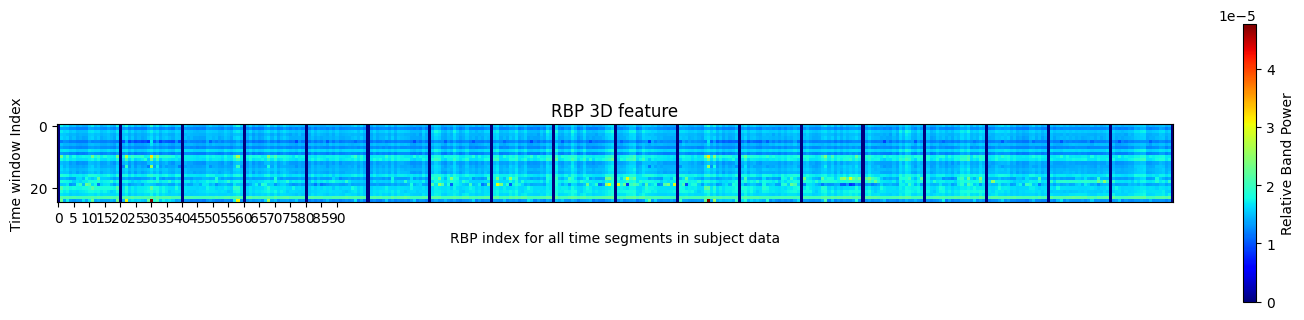

In [125]:
import numpy as np
import matplotlib.pyplot as plt
min_value = 1  # Minimum value for index3
max_value = 85 # Maximum value for index3
w=45
plt.figure(figsize=(18, 12))
index3 = random.randint(min_value, max_value)
#print(train_labels_s[index3][w])
#labelx=train_labels_s[index3][w]
#train_data_rbp5D=train_data_s[index3][w].reshape((19, 10001,1))
#print(train_data_rbp5D.shape)
# Reshape the data to (19, 5, 1)
#train_data_rbp5D = train_data_rbp[index3][w].reshape((19,45, 1))
#train_data_rbp5D=np.array(results_subjects_rbp[w]).reshape(len(results_subjects_rbp[w]),95,1)
#train_data_rbp5D=np.array(results_subjects[0]).reshape(361,408,1)
#train_data_square = train_data_rbp5D.reshape(19, n, n, 1)
train_data_rbp5D=np.array(np.abs(results_subjects_cc[w]).reshape(len(results_subjects_rbp[w]),361,1))

# Plot the EEG data as an image
plt.imshow(train_data_rbp5D[:, :, 0], cmap='jet')  
plt.title(f'RBP 3D feature')
plt.xlabel('RBP index for all time segments in subject data')
plt.ylabel('Time window Index')
#plt.yticks(range(5))
plt.xticks(range(0,95,5))
plt.colorbar(label='Relative Band Power', orientation='vertical', shrink=0.3)
plt.show()




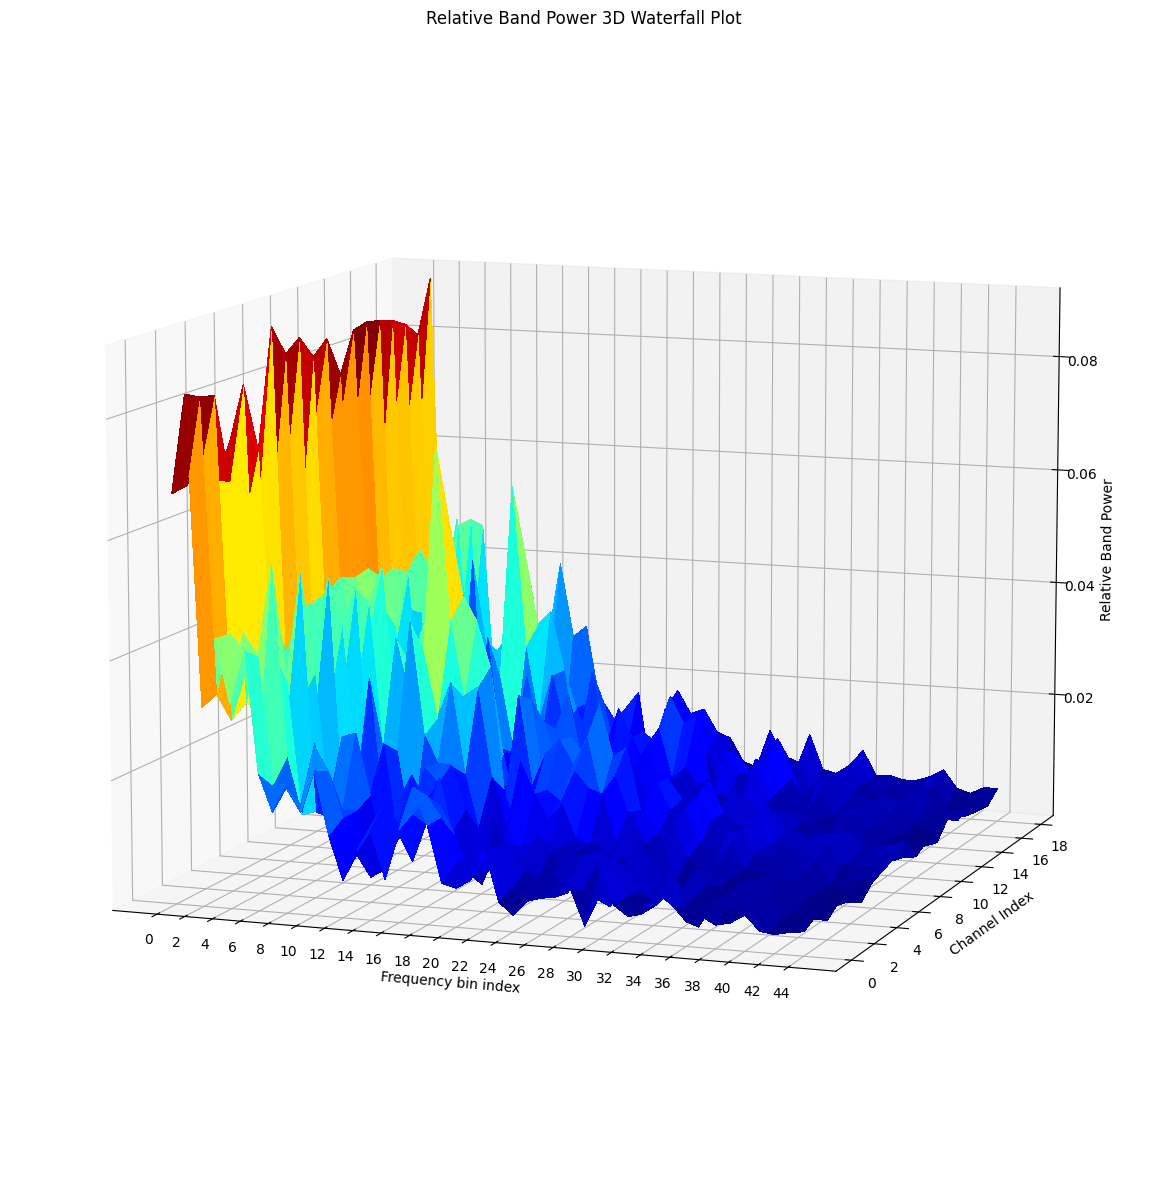

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming train_data_rbp5D is your 3D data array
# Adjust the dimensions based on your actual data
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')
sizek=45
# Create meshgrid for X and Y axes
X, Y = np.meshgrid(np.arange(sizek), np.arange(train_data_rbp5D.shape[0]))

# Plot the surface with color representing amplitude
surf = ax.plot_surface(X, Y, train_data_rbp5D[:, :, 0], cmap='jet', rstride=1, cstride=1, linewidth=0, antialiased=False)

ax.set_title('Relative Band Power 3D Waterfall Plot')
ax.set_xlabel('Frequency bin index')
ax.set_ylabel('Channel Index')
ax.set_zlabel('Relative Band Power')
ax.set_zlim([np.min(train_data_rbp5D), np.max(train_data_rbp5D)])  # Adjust the z-axis limits as needed
ax.set_xticks(range(0,sizek,2))
ax.set_yticks(range(0,19,2))

# Rotate the plot for better visibility
ax.view_init(elev=10, azim=-70)  # Adjust the viewing angle as needed

# Adjust layout for better label visibility
fig.tight_layout()

# Add colorbar
#cbar = fig.colorbar(surf, ax=ax, label='Amplitude', orientation='vertical', shrink=0.5)

plt.show()



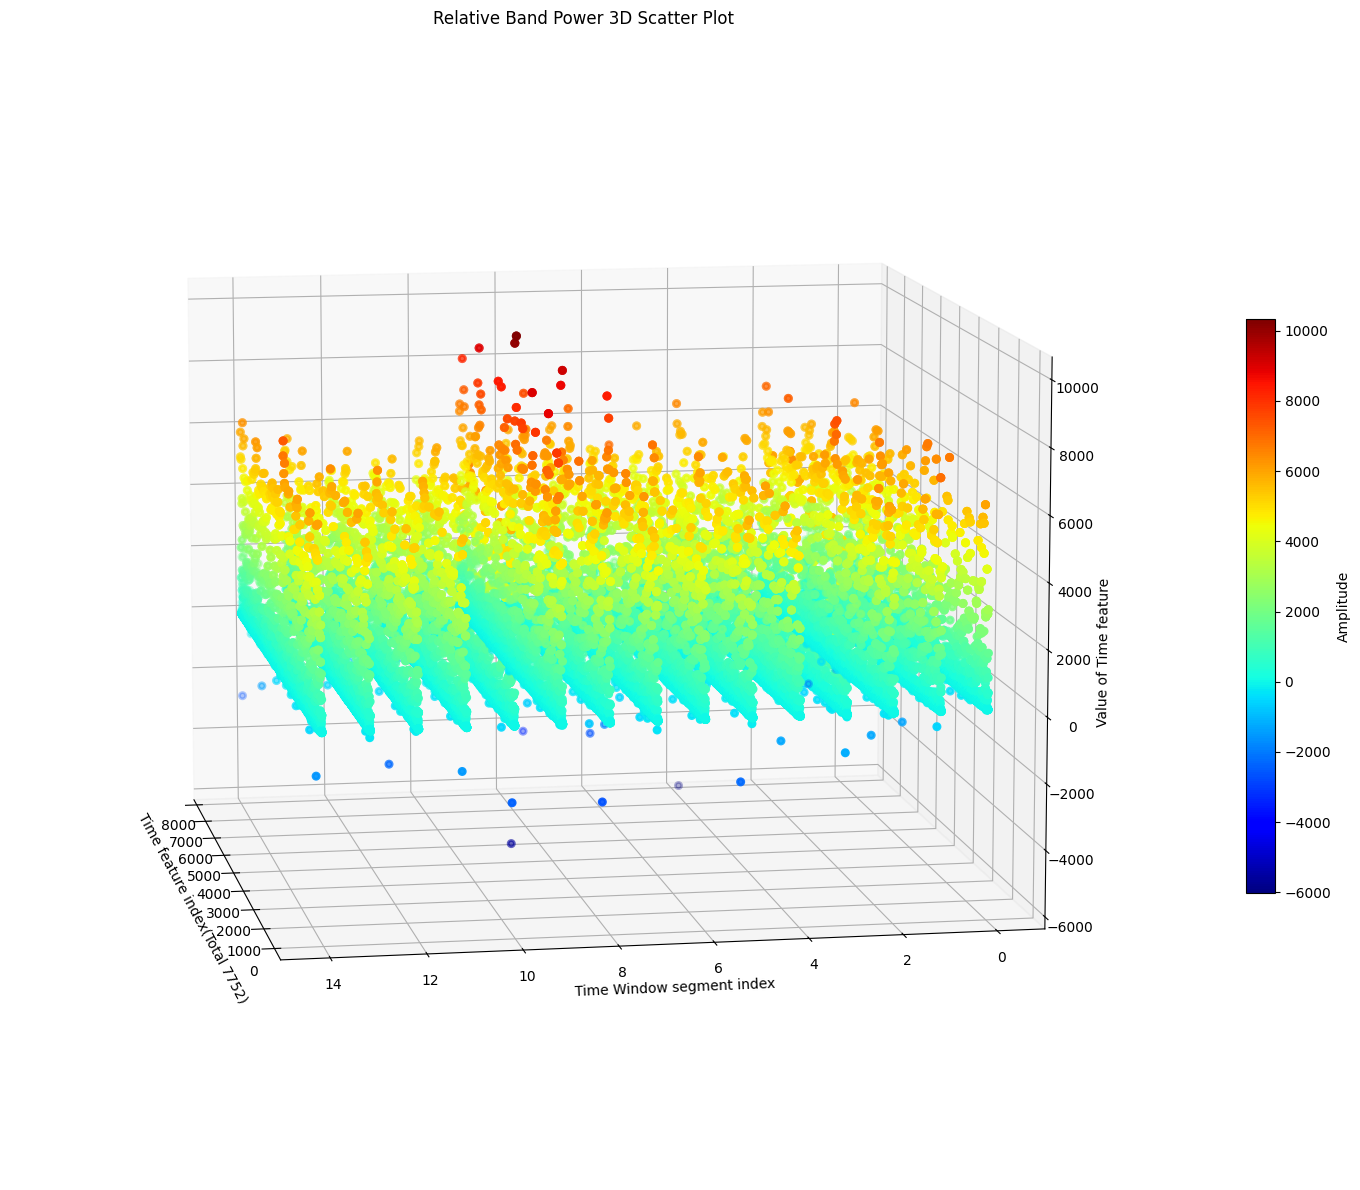

In [153]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors
from matplotlib.ticker import FormatStrFormatter
w=69
#train_data_rbp5D=np.array(np.abs(results_subjects_cc[w]).reshape(len(results_subjects_cc[w]),361,1))
train_data_rbp5D=np.array(results_subjects[w]).reshape(len(results_subjects[w]),7752,1)
# Assuming train_data_rbp5D is your 3D data array
# Adjust the dimensions based on your actual data
fig = plt.figure(figsize=(18, 12))
ax = fig.add_subplot(111, projection='3d')
sizek = 7752

# Create meshgrid for X and Y axes
X, Y = np.meshgrid(np.arange(sizek), np.arange(train_data_rbp5D.shape[0]))

# Flatten X, Y, and Z arrays for ScalarMappable
x_flat = X.flatten()
y_flat = Y.flatten()
z_flat = train_data_rbp5D[:, :sizek, 0].flatten()

# Create ScalarMappable to map viridis colormap to z values
norm = colors.Normalize(z_flat.min(), z_flat.max())
mapper = cm.ScalarMappable(norm=norm, cmap=cm.jet)

# Plot the 3D scatter plot with color representing amplitude using viridis colormap
for i in range(train_data_rbp5D.shape[0]):
    colors = mapper.to_rgba(train_data_rbp5D[i, :sizek, 0])
    ax.scatter(X[i, :], Y[i, :], train_data_rbp5D[i, :sizek, 0], c=colors, linewidth=2)

ax.set_title('Relative Band Power 3D Scatter Plot')
ax.set_xlabel('Time feature index(Total 7752)')
ax.set_ylabel('Time Window segment index')
ax.set_zlabel('Value of Time feature')
ax.set_zlim([np.min(train_data_rbp5D), np.max(train_data_rbp5D)])  # Adjust the z-axis limits as needed
#ax.set_xticks(range(0, sizek, 170))
ax.set_yticks(range(0, len(results_subjects[w]), 2))

# Add colorbar
cbar = fig.colorbar(mapper, ax=ax, label='Amplitude', orientation='vertical', shrink=0.5)

# Rotate the plot for better visibility
ax.view_init(elev=10, azim=170)  # Adjust the viewing angle as needed
#ax.zaxis.set_major_formatter(FormatStrFormatter('%.1e'))

fig.tight_layout()

plt.show()



In [ ]:
train_data_rbp=train_data_s


In [ ]:
train_data_rbp=train_data_s
train_labels=train_labels_s

## Model MLP training loop

In [ ]:
#!pip install --upgrade tensorflow

from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.initializers import HeNormal

from collections import Counter

num_ensable_models=1

train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_channels = train_data_rbp[0][0].shape[0]
num_frequency_bands = train_data_rbp[0][0].shape[1]

loo = LeaveOneOut()

average_accuracy = []

confusion_true_MLP = []
confusion_pred_MLP = []

histories_MLP=[]

ensemble_predictions=[]

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")
    
    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
        # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)
        # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])
    
    individual_model_predictions = []
    for _ in range(num_ensable_models):
        tf.keras.backend.clear_session()
        model_MLP = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(num_channels, num_frequency_bands)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
            tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal()) 
        ])


        optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
        model_MLP.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])


        # Train the model
        history_MLP = model_MLP.fit(train_data_reshaped, np.array(train_labels_concat),
                                    epochs=1, batch_size=256, verbose=1, callbacks=[EarlyStop, ReduceLR])
        histories_MLP.append(history_MLP)


        # Predict on test data
        test_pred = model_MLP.predict(test_data)

        # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
        threshold = 0.5
        test_pred_binary = (test_pred > threshold).astype(int)
        
        individual_model_predictions.append(test_pred_binary.flatten())
    
    ensemble_prediction = np.array([Counter(pred).most_common(1)[0][0] for pred in zip(*individual_model_predictions)])
    ensemble_predictions.append(ensemble_prediction)
    
    # Calculate accuracy manually
    
    test_acc = np.mean(ensemble_prediction == test_labels_concat)
    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_MLP.extend(test_labels_concat)
    confusion_pred_MLP.extend(ensemble_prediction.flatten())

#average_accuracy = np.mean(average_accuracy)
#print(f"Average Test Accuracy: {average_accuracy:.4f}")

#ensemble_accuracy = np.mean(ensemble_predictions) == confusion_true_MLP)
#print(f"Ensemble Test Accuracy: {ensemble_accuracy:.4f}")

print("Leave-One-Subject-Out validation complete.")

calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP,'MLP Confusion Matrix')

In [ ]:
calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP,'MLP Confusion Matrix')

## Model MMSE ESTIMATION using RMSE loss  training loop

In [ ]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 
from tensorflow.keras.initializers import GlorotNormal, HeNormal
import matplotlib.pyplot as plt

train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="mean_squared_error", factor=0.3, patience=4, verbose=1, mode="min", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="mean_squared_error",patience=10,verbose=1,mode="min",restore_best_weights=True)



num_subjects = len(train_data_rbp)
num_channels = train_data_rbp[0][0].shape[0]
num_frequency_bands = train_data_rbp[0][0].shape[1]

loo = LeaveOneOut()

all_rmse = []
label_pred=[]
label_true=[]

histories_MMSE = []


for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")
  
   

    tf.keras.backend.clear_session()
    model_MMSE = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(num_channels, num_frequency_bands)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
    tf.keras.layers.Dense(1, activation='linear', kernel_initializer=GlorotNormal()),
   

])
    input_shape = train_data_rbp2d[0][0].shape

    #model_MMSE=create_CNN2D_model(input_shape)
    #model_MMSE = create_LSTM_model(input_shape)
    #model_MMSE=model_CNN_1D_multi_head_BUILD((num_channels, num_frequency_bands))
    
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_MMSE.compile(optimizer=optimizer_ADAM, loss='mean_squared_error', metrics=['mean_squared_error'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding the current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_MMSE = model_MMSE.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=64, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_MMSE.append(history_MMSE)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data
    test_pred = model_MMSE.predict(test_data)

    # Calculate RMSE manually
    test_rmse = np.sqrt(np.mean((test_pred.flatten() - test_labels_concat)**2))
    
    label_pred.append(test_pred.flatten())
    label_true.append(test_labels_concat)

    print(f"Test RMSE: {test_rmse:.4f}")
    print("=" * 30)

    all_rmse.append(test_rmse)
    

average_rmse = np.mean(all_rmse)
print(f"Average Test RMSE: {average_rmse:.4f}")
print("Leave-One-Subject-Out validation complete.")




In [ ]:
# Plot the training loss for each iteration
plt.figure(figsize=(10, 6))
for history in histories_MMSE:
    plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error Loss')
plt.title('Training Loss Over Epochs for Each Subject')
plt.legend()
plt.show()
# ... (your existing code)

# Plot all samples' predictions and actual labels
plt.figure(figsize=(15, 9))

#for subject_idx in range(num_subjects):
    # Plot predictions and actual labels for each subject with different colors
 #   plt.scatter(label_true[subject_idx], label_pred[subject_idx], label=f'Subject {subject_idx + 1}', alpha=0.7)
#for x in label_pred:
#    print(x)
vix_true =  np.concatenate(label_true, axis=0)
vix_pred =  np.concatenate(label_pred, axis=0)

plt.plot(vix_true)
plt.plot(vix_pred)

plt.xlabel('Sample idx')
plt.ylabel('MMSE value')
plt.title('MMSE for each sample True vs Prediction')
plt.legend(['True','Pred'])
plt.show()

plt.figure(figsize=(10, 6))

plt.step(range(len(all_rmse)),all_rmse)

plt.xlabel('Subject idx')
plt.ylabel('RMSE value')
plt.title('Average RMSE for each test batch')
plt.legend(['Average RMSE'])
plt.show()


In [ ]:
plot_accuracy(histories_MLP)

In [ ]:

print("Leave-One-Subject-Out validation complete.")
calculate_metrics_and_plot(confusion_true_MLP, confusion_pred_MLP,'MLP Confusion Matrix')

## Model CNN 1D MULTI-HEAD  training loop

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score, confusion_matrix

train_labels=train_labels_s

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# Assuming train_data_rbp and train_labels are your python lists
# train_data_rbp: [num_subjects, num_epochs, num_channels, num_frequency_bands]
# train_labels: [num_subjects]

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

loo = LeaveOneOut()

average_accuracy = []
confusion_true_CNN = []
confusion_pred_CNN = []
histories_CNN = []

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()
    model_CNN_1D_multi_head = model_CNN_1D_multi_head_BUILD((num_channels, num_frequency_bands))
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN_1D_multi_head.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    # Separate current subject's data for testing
    test_data = np.array(train_data_rbp[subject_idx])
    test_labels_concat = np.array(train_labels[subject_idx])

    # Combine data from other subjects for training
    train_data = []
    train_labels_concat = []
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            train_data.extend(data)
            train_labels_concat.extend(train_labels[idx])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train the model
    history_CNN = model_CNN_1D_multi_head.fit(train_data_reshaped, np.array(train_labels_concat),
                                             epochs=10, batch_size=64, verbose=1, callbacks=[EarlyStop, ReduceLR])
    histories_CNN.append(history_CNN)

    # Predict on test data
    test_pred = model_CNN_1D_multi_head.predict(test_data)

    # Convert prediction to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy and confusion matrix
    test_acc = accuracy_score(test_labels_concat, test_pred_binary)
    confusion_true_CNN.extend(test_labels_concat)
    confusion_pred_CNN.extend(test_pred_binary.flatten())

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")

# Calculate and print confusion matrix
#confusion_matrix_CNN = confusion_matrix(confusion_true_CNN, confusion_pred_CNN)
#print("Confusion Matrix:")
#print(confusion_matrix_CNN)



In [ ]:
calculate_metrics_and_plot(confusion_true_CNN, confusion_pred_CNN,'CNN2D Confusion Matrix')

In [ ]:
plot_accuracy(histories_CNN)

## Model CNN 2D training loop

In [ ]:
print(train_data_rbp2d[0][0].shape)

In [ ]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp2d[0].shape[0]
num_channels = train_data_rbp2d[0].shape[1]
num_frequency_bands = train_data_rbp2d[0].shape[2]


learning_rate = 0.001  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

num_subjects = len(train_data_rbp2d)

loo = LeaveOneOut()

average_accuracy = []

confusion_true_CNN2D = []
confusion_pred_CNN2D = []  # Changed from confusion_pred_MLP

histories_CNN2D = []  # Changed from histories_MLP

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # Define the CNN2D model
       # Assuming input_shape is the shape of your input data
    input_shape = train_data_rbp2d[0][0].shape
    print(input_shape)

    model_CNN2D=create_CNN2D_model(input_shape)
    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
    model_CNN2D.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])
    
    train_data_concat = []
    train_labels_concat = []
    # Construct the training set excluding current subject's data
    for idx, data in enumerate(train_data_rbp2d):
        if idx != subject_idx:
            # Concatenate data along the first axis (axis=0)
            train_data_concat.extend(data)
            # Concatenate labels
            train_labels_concat.extend(train_labels[idx])

    # Concatenate the lists of arrays to create final numpy arrays
    
    #train_data_concatenated = np.concatenate(train_data_concat, axis=0)
    #train_data_concatenated=np.array(train_data_concat)
    train_labels_concatenated = np.array(train_labels_concat)

    # Reshape the training data to match the model's input shape
    #train_data_reshaped = train_data_concatenated.reshape(-1, num_channels, num_frequency_bands, 1)
    train_data_reshaped = np.array(train_data_concat).reshape(-1, num_channels, num_frequency_bands,1)
    print(train_data_reshaped.shape)
    # Train the CNN2D model
    history_CNN2D = model_CNN2D.fit(train_data_reshaped, train_labels_concatenated,
                                     epochs=15, batch_size=64, verbose=0, callbacks=[EarlyStop, ReduceLR])

    histories_CNN2D.append(history_CNN2D)

    # Test on the current subject's data
    test_data = np.array(train_data_rbp2d[subject_idx])
    test_labels = np.array(train_labels[subject_idx])

    # Predict using the CNN2D model
    test_pred = model_CNN2D.predict(test_data)

    # Convert predictions to binary (0 or 1) based on a threshold (0.5 for example)
    threshold = 0.5
    test_pred_binary = (test_pred > threshold).astype(int)

    # Calculate accuracy manually
    test_acc = np.mean(test_pred_binary.flatten() == test_labels)

    print(f"Test Accuracy: {test_acc:.4f}")
    print("=" * 30)

    average_accuracy.append(test_acc)

    confusion_true_CNN2D.extend(test_labels)  # Changed from confusion_true_MLP
    confusion_pred_CNN2D.extend(test_pred_binary.flatten())  # Changed from confusion_pred_MLP

average_accuracy = np.mean(average_accuracy)
print(f"Average Test Accuracy: {average_accuracy:.4f}")
print("Leave-One-Subject-Out validation complete.")


In [ ]:
calculate_metrics_and_plot(confusion_true_CNN2D, confusion_pred_CNN2D,'CNN2D Confusion Matrix')

In [ ]:
plot_accuracy(histories_CNN2D)


In [ ]:
def visualize_activation_maps(model, samples, labels, colormap):
    random_subject_index = np.random.randint(len(samples))
    random_epoch_index = np.random.randint(samples[random_subject_index].shape[0])
    sample = np.expand_dims(samples[random_subject_index][random_epoch_index], axis=0)  # Random subject and epoch
    label = labels[random_subject_index][random_epoch_index]  # Corresponding label

    layer_outputs = [layer.output for layer in model.layers[1:]]  # Skip input layer and flatten layer
    activation_model = Model(inputs=model.input, outputs=layer_outputs)
    activations = activation_model.predict(sample)

    # Original sample
    plt.figure(figsize=(30, 10))
    
    plt.subplot(1, len(activations) + 1, 1)
    plt.imshow(np.squeeze(sample[0]), cmap=colormap)
    plt.title('Input Image\nLabel: {}'.format(label))
    plt.axis('off')
    # Add a colorbar to explain magnitudes of the displayed colors
    cbar = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    cbar.set_label('Input Magnitude')  # You can customize the colorbar label if needed


    # Activation maps for each layer
    for i, (layer_name, activation_map) in enumerate(zip([layer.name for layer in model.layers[1:]], activations)):
        plt.subplot(1, len(activations) + 1, i + 2)
        if len(activation_map.shape) == 4:  # 4D activation map (batch_size, width, height, channels)
            # Average activation across channels
            avg_activation = np.mean(activation_map[0], axis=-1)
            plt.imshow(avg_activation, cmap=colormap)
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        elif len(activation_map.shape) == 2:  # 2D activation map (batch_size, features)
            plt.imshow(np.expand_dims(activation_map[0], axis=0), cmap=colormap, aspect='auto')
            plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
        plt.title(layer_name)
        plt.axis('off')

    # Print the network prediction under the title of the last activation map
    prediction = model.predict(sample)
    plt.title('{}\nNetwork Prediction: {}'.format(layer_name, prediction))
    
    # Add a colorbar to explain magnitudes of the displayed colors
    #cbar2 = plt.colorbar(orientation='horizontal', fraction=0.1, pad=0.02)
    #cbar2.set_label('Prediction Magnitude')  # You can customize the colorbar label if needed

    plt.show()

# Example usage
colormap = 'viridis'

visualize_activation_maps(model_CNN2D, train_data_rbp2d, train_labels_s, colormap)


In [ ]:
from IPython.display import display
from tensorflow.keras.utils import plot_model

# Visualize the model architecture in the Jupyter Notebook
plot_model(model_CNN2D, show_shapes=True, show_layer_names=True)

# Display the model diagram inline in the Jupyter Notebook
display()


## Model RNN training loop

In [ ]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random

train_labels=train_labels_s

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

average_accuracy_RNN = []
confusion_true_RNN = []
confusion_pred_RNN = []
histories_RNN = []

learning_rate = 0.005  # Learning rate for the optimizer
beta_1 = 0.9  # Exponential decay rate for the first moment estimates
beta_2 = 0.999  # Exponential decay rate for the second moment estimates
epsilon = 1e-7  # A small constant for numerical stability

ReduceLR = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="accuracy", factor=0.3, patience=4, verbose=1, mode="max", min_lr=0.00005)

EarlyStop = tf.keras.callbacks.EarlyStopping(
    monitor="accuracy",patience=10,verbose=1,mode="max",restore_best_weights=True)

optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)
# ... (Assume train_data_rbp2d, train_labels, learning_rate, beta_1, beta_2, epsilon, ReduceLR, EarlyStop are defined)

for subject_idx in range(num_subjects):
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    tf.keras.backend.clear_session()

    # RNN Model
    model_RNN = tf.keras.Sequential([
    tf.keras.layers.Reshape((1, num_channels * num_frequency_bands), input_shape=(num_channels, num_frequency_bands)),
    tf.keras.layers.BatchNormalization(),
    
    # First SimpleRNN layer
    tf.keras.layers.LSTM(8, activation='relu', return_sequences=True),
    tf.keras.layers.Dropout(0.5),

    # Second SimpleRNN layer
    tf.keras.layers.LSTM(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    # Fully connected layer
    tf.keras.layers.Flatten(),
   
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='relu', kernel_initializer=HeNormal()),
    tf.keras.layers.Dense(1, activation='sigmoid',kernel_initializer=GlorotNormal()) 
    ])


    optimizer_ADAM = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, beta_2=beta_2, epsilon=epsilon)

    # Compile RNN Model
    model_RNN.compile(optimizer=optimizer_ADAM, loss='binary_crossentropy', metrics=['accuracy'])

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])

    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels, num_frequency_bands)

    # Train RNN Model
    history_RNN = model_RNN.fit(train_data_reshaped, np.array(train_labels_concat),
                                epochs=20, batch_size=64, verbose=0, callbacks=[EarlyStop, ReduceLR])
    histories_RNN.append(history_RNN)

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels, num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data for RNN
    test_pred_RNN = model_RNN.predict(test_data)
    threshold_RNN = 0.5
    test_pred_binary_RNN = (test_pred_RNN > threshold_RNN).astype(int)
    
    confusion_true_RNN.extend(test_labels_concat)  # Changed from confusion_true_MLP
    confusion_pred_RNN.extend(test_pred_binary_RNN.flatten())  # Changed from confusion_pred_MLP


    # Calculate accuracy manually for RNN
    test_acc_RNN = np.mean(test_pred_binary_RNN == test_labels_concat)
    print(f"RNN Test Accuracy: {test_acc_RNN:.4f}")

    print("=" * 30)

    average_accuracy_RNN.append(test_acc_RNN)

average_accuracy_RNN = np.mean(average_accuracy_RNN)
print(f"Average RNN Test Accuracy: {average_accuracy_RNN:.4f}")
print("Leave-One-Subject-Out validation complete.")


In [ ]:
calculate_metrics_and_plot(confusion_true_RNN, confusion_pred_RNN,'LSTM Confusion Matrix')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model



# Get the list of layers in the model
layers = model_RNN.layers

# Visualize weights
for i, w in enumerate(weights):
    w_shape = w.shape

    if len(w_shape) == 2:
        # 2D weights (Dense layer)
        plt.figure(figsize=(10, 5))
        plt.imshow(w, cmap='viridis', interpolation='none')
        plt.title(f'{layer.name} - Weight {i + 1}')
        plt.colorbar()
        plt.show()

    elif len(w_shape) == 3 and w_shape[2] in [3, 4]:
        # 3D weights with channels (Convolutional layer)
        plt.figure(figsize=(10, 5))
        plt.subplot(1, w_shape[2], i + 1)
        plt.imshow(w, cmap='viridis', interpolation='none')
        plt.title(f'{layer.name} - Weight {i + 1}')
        plt.colorbar()
        plt.show()

# Visualize biases if available
if len(weights) > 1:
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(weights[1])), weights[1])
    plt.title(f'{layer.name} - Bias')
    plt.show()



In [ ]:
!pip install torch
!pip install tabpfn
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score
import warnings
import gc
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns

num_subjects = len(train_data_rbp)
num_epochs = train_data_rbp[0].shape[0]
num_channels = train_data_rbp[0].shape[1]
num_frequency_bands = train_data_rbp[0].shape[2]

def remove_models_from_memory():
    # Iterate over all objects in the global scope
    for obj_name in list(globals()):
        obj = globals()[obj_name]
        if isinstance(obj, torch.nn.Module):
            # If the object is a PyTorch model, delete it
            del globals()[obj_name]
warnings.filterwarnings("ignore", category=UserWarning)
X_new=train_data_rbp
labels=train_labels_s
success_arr = []
predictions = []
predictions_prob = []
for x,y in zip(X_new,labels):
    print(x.shape)
    print(y.shape)
    print(len(x))
    print(len(y))

for current in range(len(X_new)):
    remove_models_from_memory()
    print(f"Leave-One-Subject-Out: Testing on subject {current + 1}/{len(X_new)}")
    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=5)
    x_train = X_new
    y_train = labels
    x_test = (x_train.pop(current)).reshape(1,-1)
    y_train= np.array(y_train.pop(current))
    x_train = np.concatenate(x_train, axis=0)
    #x_train = np.concatenate(x_train, axis=2)
    print(x_train.shape)
    
    y_test = (y_train.pop(current))
    y_train =  np.concatenate(y_train, axis=0)
    print(y_train.shape)
    classifier.fit(x_train, y_train)
    y_pred, p_pred = classifier.predict(x_test, return_winning_probability=True)
    #clf = RandomForestClassifier(n_estimators=1000, random_state=42)
    
    # Fit the classifier to the training data]
    #clf.fit(x_train, y_train)
    
    # Make predictions on the test data
    #y_pred = clf.predict(x_test)
    predictions.append(y_pred)
    predictions_prob.append(p_pred)
    
confusion_mtx = confusion_matrix(labels, predictions)

# Define class names
class_names = ["Control group(0)", "Alzheimer group(1)"]

# Calculate accuracy, sensitivity, specificity, precision, and F1-score
accuracy = accuracy_score(labels, predictions)
precision = precision_score(labels, predictions)
recall = recall_score(labels, predictions)
f1 = f1_score(labels, predictions)
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

# Output metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(labels, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
from sklearn.model_selection import LeaveOneOut
import numpy as np
import tensorflow as tf
import random 
#!pip install torch
#!pip install tabpfn
from tabpfn import TabPFNClassifier
import time
from sklearn.metrics import accuracy_score
import warnings
import gc
from sklearn.ensemble import RandomForestClassifier
import torch
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns



train_labels=train_labels_s

def remove_models_from_memory():
    # Iterate over all objects in the global scope
    for obj_name in list(globals()):
        obj = globals()[obj_name]
        if isinstance(obj, torch.nn.Module):
            # If the object is a PyTorch model, delete it
            del globals()[obj_name]
warnings.filterwarnings("ignore", category=UserWarning)


average_accuracy = []

true_labels=[]
predictions_prob=[]
predictions=[]
for subject_idx in range(num_subjects):
    remove_models_from_memory()
    print(f"Leave-One-Subject-Out: Testing on subject {subject_idx + 1}/{num_subjects}")

    train_data = []
    train_labels_concat = []

    # Construct the training set excluding current subject's epochs
    for idx, data in enumerate(train_data_rbp):
        if idx != subject_idx:
            # Shuffle the indices for data and corresponding labels
            shuffled_indices = list(range(len(data)))
            random.shuffle(shuffled_indices)
            for shuffled_idx in shuffled_indices:
                train_data.extend(data[shuffled_idx])
                # Convert the label to a list before extending
                train_labels_concat.extend([train_labels[idx][shuffled_idx]])
                
    # Reshape the training data to match the model's input shape
    train_data_reshaped = np.array(train_data).reshape(-1, num_channels* num_frequency_bands)

    classifier = TabPFNClassifier(device='cpu', N_ensemble_configurations=9)
    print(train_data_reshaped.shape)
    print (np.array(train_labels_concat).shape)
    classifier.fit(train_data_reshaped, np.array(train_labels_concat),overwrite_warning=True)
    
 
  

    # Test on the current subject's epochs
    test_data = np.array(train_data_rbp[subject_idx]).reshape(-1, num_channels* num_frequency_bands)
    test_labels_concat = np.array(train_labels[subject_idx])

    # Predict on test data
    y_pred, p_pred = classifier.predict(test_data, return_winning_probability=True)
       # Calculate accuracy manually
    test_acc = np.mean(y_pred == test_labels_concat)

    print(f"Test Accuracy: {test_acc:.4f}")
    true_labels.append(test_labels_concat)
    predictions.append(y_pred)
    
    predictions_prob.append(p_pred)

  
print("Leave-One-Subject-Out validation complete.")


In [ ]:
from sklearn.metrics import confusion_matrix

true_labels_flat = np.concatenate(true_labels)
predictions_flat = np.concatenate(predictions)
predictions_prob_flat = np.concatenate(predictions_prob)

confusion_mtx = confusion_matrix(true_labels_flat, predictions_flat)

# Define class names
class_names = ["Control group(0)", "Alzheimer group(1)"]

# Calculate accuracy, sensitivity, specificity, precision, and F1-score
accuracy = accuracy_score(true_labels_flat, predictions_flat)
precision = precision_score(true_labels_flat, predictions_flat)
recall = recall_score(true_labels_flat, predictions_flat)
f1 = f1_score(true_labels_flat, predictions_flat)
specificity = confusion_mtx[0, 0] / (confusion_mtx[0, 0] + confusion_mtx[0, 1])

# Output metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Sensitivity (Recall):", recall)
print("Specificity:", specificity)
print("F1-score:", f1)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, thresholds = roc_curve(true_labels_flat, predictions_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
